## Setup

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

Here, we implement the loss functions that we try to minimize. 

In [1]:
# Python Libraries
import  os;
from    typing              import      List, Dict, Tuple;

# External libraries. 
import  numpy;
import  matplotlib.pyplot       as      plt;
import  matplotlib              as      mpl;
import  seaborn;
import  torch;
from    torch.utils.tensorboard import  SummaryWriter;
from    scipy                   import  interpolate;

# My code
from    Model   import  Cheyne              as F_Model;
from    X0      import  Affine              as X0_Model;
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL;
from    Loss    import  Running_Cost, Terminal_Cost, Integral_Loss;

# Set up the TensorBoard SummaryWriter
Base_Dir    : str   = "./Logs";
Counter     : int   = 0;
Log_Dir     : str   = os.path.join(Base_Dir, "Version_" + str(Counter));
while(os.path.isdir(Log_Dir) == True):
    Counter += 1;
    Log_Dir  = os.path.join(Base_Dir, "Version_" + str(Counter));
TB_Writer = SummaryWriter(log_dir = Log_Dir);

# Set up the logger setup.
import  logging;
Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# Set up cost functions.
l = Running_Cost();
G = Terminal_Cost(Weight = 0.1);

# Set up plotting. 
Initialize_MPL();

### Generate Target Trajectory

Generate the target trajectory and plot it!

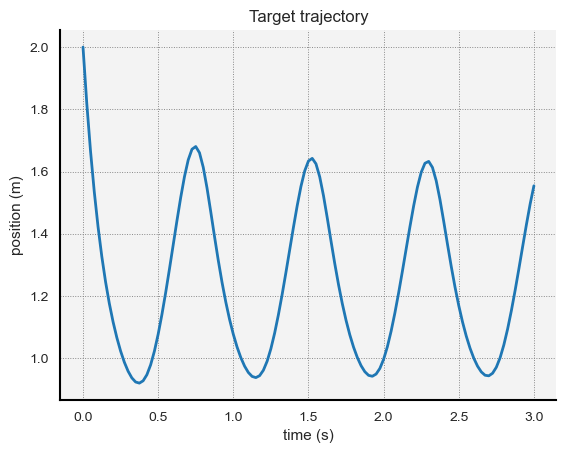

In [2]:
# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(p = 5.0, V0 = 6.5, a = 2.0, m = 8);
a_Target        = torch.Tensor([0.5]);
b_Target        = torch.Tensor([2]);
X0_Target       = X0_Model(a = a_Target, b = b_Target);
tau_Target      = torch.tensor(0.25);
T_Target        = torch.tensor(3.0);

# Get the target trajectory!
x_Target, t_Target  = DDE_Solver(F = F_Target, X0 = X0_Target, tau = tau_Target, T = T_Target);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_Target[0, :].reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("Target trajectory");

### Train the model

In [3]:
from    Model       import      Neural;

# Pick a starting position, tau, and x0
tau     = (tau_Target + 0.2).clone().detach().requires_grad_(True);
a       = (a_Target + 0.1).clone().detach().requires_grad_(True);
b       = (b_Target - 0.1).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
Widths      = [3, 10, 10, 1];
#F_MODEL     = Neural(Widths = Widths);
F_MODEL     = F_Model(p = 4.0, V0 = 9.0, a = 1.8, m = 8);
X0_MODEL    = X0_Model(a, b);

# Settings for training
N_Epochs        : int       = 1000;
Learning_Rate   : float     = 0.04;
Loss_Threshold  : float     = 0.001;             # Will exit when loss drops below this.

# Set up the DDE Module
DDE_Module  = NDDE(F = F_MODEL, X0 = X0_MODEL);


# Select the optimizer, number of epochs.
Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs, 
                                            eta_min     = Learning_Rate/10.);

# Train!
t_Predict, x_Predict  = Train(  DDE_Module      = DDE_Module, 
                                tau             = tau, 
                                T               = T, 
                                N_Epochs        = N_Epochs, 
                                x_Target        = x_Target, 
                                t_Target        = t_Target, 
                                l               = l,
                                G               = G,
                                Loss_Threshold  = Loss_Threshold, 
                                Optimizer       = Optimizer, 
                                Scheduler       = Scheduler,
                                Writer          = TB_Writer);

  10:   Loss = 2.67246  | tau = 0.24552  | grad tau = -21.99218
  20:   Loss = 1.32128  | tau = 0.24336  | grad tau = -12.06305
  30:   Loss = 0.68841  | tau = 0.24928  | grad tau =  -7.08381
  40:   Loss = 0.41076  | tau = 0.25085  | grad tau =  -2.80786
  50:   Loss = 0.31626  | tau = 0.25271  | grad tau =   4.56614
  60:   Loss = 0.21717  | tau = 0.24813  | grad tau =   3.59957
  70:   Loss = 0.11895  | tau = 0.24368  | grad tau =   0.47736
  80:   Loss = 0.08399  | tau = 0.24306  | grad tau =  -3.00320
  90:   Loss = 0.03079  | tau = 0.24456  | grad tau =   1.55609
 100:   Loss = 0.01131  | tau = 0.24291  | grad tau =   1.27984
 110:   Loss = 0.00227  | tau = 0.24440  | grad tau =   0.56056
converged after 117 epochs


### Plot the Predicted vs Target trajectories

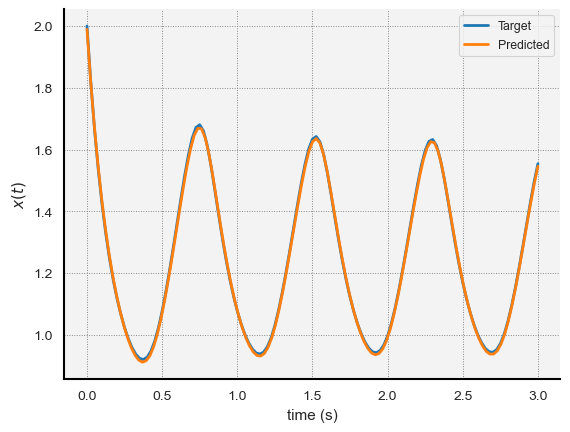

In [4]:
####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_Target[0].detach().numpy(),   label = "true");
plt.plot(t_Predict, x_Predict[0].detach().numpy(),  label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);

### Plot the loss as a function of $\tau$

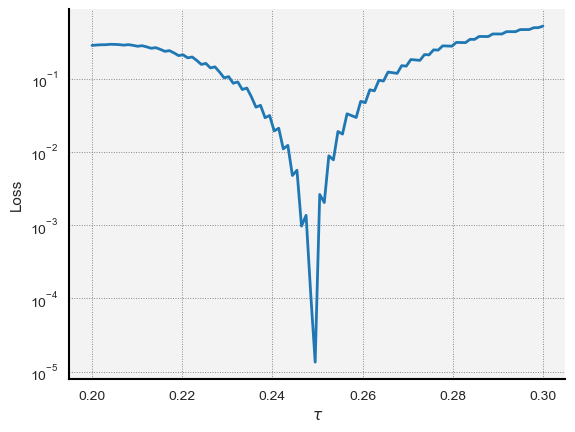

In [5]:
####################################################################################################
# Plot loss as a function of tau


# Build initial model
Model = F_Target;

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 100;
grid_tau = torch.linspace(0.2, 0.3, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(Model, X0_Target, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Target.detach().numpy(), x_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Integral_Loss(Predictions_i, Targets_i, t_Values, l) + G(Targets_i[:, -1], Predictions_i[:, -1]);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");

### Serialize the model

In [36]:
# First, find a save name
Base_Name   : str   = "Neural";
Save_Dir    : str   = os.path.join(os.curdir, "Saves");
Counter     : int   = 0;

Save_Path   : str   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));
while(os.path.isfile(Save_Path)):
    Counter    += 1;
    Save_Path   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));

# Now, serialize the model. 
F_State_Dict    : dict  = F_MODEL.state_dict();
X0_State_Dict   : dict  = X0_MODEL.state_dict();
Save_Dict       : dict  = {"F" : F_State_Dict, "Widths" : Widths, "X0" : X0_State_Dict, "tau" : tau};
torch.save(Save_Dict, Save_Path);